### Sample notebook file to perform inference with trained models


Requires onnx libraries to use sharable models

`pip install onnxruntime`

`pip install onnx`

In [1]:
import onnx

# Step 1: Load the ONNX model
model_path = 'FID_NPPGAN.onnx'
model = onnx.load(model_path)

# Step 2: Get the model graph
graph = model.graph

# Step 3: Print model information
print(f"Model name: {model.graph.name}")
print(f"Model inputs:")
for input_tensor in graph.input:
    print(f" - {input_tensor.name} with shape {input_tensor.type.tensor_type.shape.dim}")

print(f"Model outputs:")
for output_tensor in graph.output:
    print(f" - {output_tensor.name} with shape {output_tensor.type.tensor_type.shape.dim}")

print(f"Model layers/operations:")
for node in graph.node:
    print(f" - {node.op_type} (name: {node.name})")

# Optional: If you want to see more detailed information, you can explore further attributes of the model
print(f"\nModel summary:")
print(f" - Number of inputs: {len(graph.input)}")
print(f" - Number of outputs: {len(graph.output)}")
print(f" - Number of nodes: {len(graph.node)}")
print(f" - Number of initializers: {len(graph.initializer)}")


Model name: Network
Model inputs:
 - inputLayer with shape [dim_param: "BatchSize"
, dim_value: 1
, dim_value: 128
, dim_value: 128
]
Model outputs:
 - fActivation with shape [dim_param: "BatchSize"
, dim_value: 1
, dim_value: 128
, dim_value: 128
]
Model layers/operations:
 - Pad (name: pad)
 - Conv (name: iConv)
 - InstanceNormalization (name: iNorm)
 - Relu (name: iActivation)
 - Pad (name: pad_1)
 - Conv (name: dConv_1)
 - InstanceNormalization (name: dNorm_1)
 - Relu (name: dActivation_1)
 - Pad (name: pad_2)
 - Conv (name: dConv_2)
 - InstanceNormalization (name: dNorm_2)
 - Relu (name: dActivation_2)
 - Pad (name: pad_3)
 - Conv (name: rConv_1_1)
 - InstanceNormalization (name: rNorm_1_1)
 - Relu (name: rActivation_1_1)
 - Pad (name: pad_4)
 - Conv (name: rConv_1_2)
 - InstanceNormalization (name: rNorm_1_2)
 - Sum (name: rAdd_1)
 - Pad (name: pad_5)
 - Conv (name: rConv_2_1)
 - InstanceNormalization (name: rNorm_2_1)
 - Relu (name: rActivation_2_1)
 - Pad (name: pad_6)
 - Conv 

## Perform generation on random input

In [2]:
import onnxruntime as ort
import numpy as np

session = ort.InferenceSession(model_path)

# Get input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Prepare input data
# Replace this with actual input data in the correct shape and format expected by your model
input_data = np.random.randn(1, 1, 128, 128).astype(np.float32)

# Step 4: Run the model
result = session.run([output_name], {input_name: input_data})

# Output the result
print(result)

[array([[[[0.5071981 , 0.42656827, 0.26923102, ..., 0.5698121 ,
          0.62014335, 0.53065157],
         [0.5511414 , 0.4493906 , 0.357726  , ..., 0.57593864,
          0.5725522 , 0.5632022 ],
         [0.47957152, 0.46419188, 0.4959173 , ..., 0.54732686,
          0.5428649 , 0.56130207],
         ...,
         [0.3329837 , 0.23542674, 0.23547648, ..., 0.4423154 ,
          0.53608596, 0.42661038],
         [0.30751368, 0.35286638, 0.35967126, ..., 0.33718207,
          0.38107374, 0.39448425],
         [0.16717255, 0.2199646 , 0.38522676, ..., 0.35879672,
          0.38794446, 0.4616053 ]]]], dtype=float32)]


In [3]:
print('shape of input_data:', input_data.shape)
print('shape of input_data:', input_data.dtype)

shape of input_data: (1, 1, 128, 128)
shape of input_data: float32


## Perform generation on sample patches

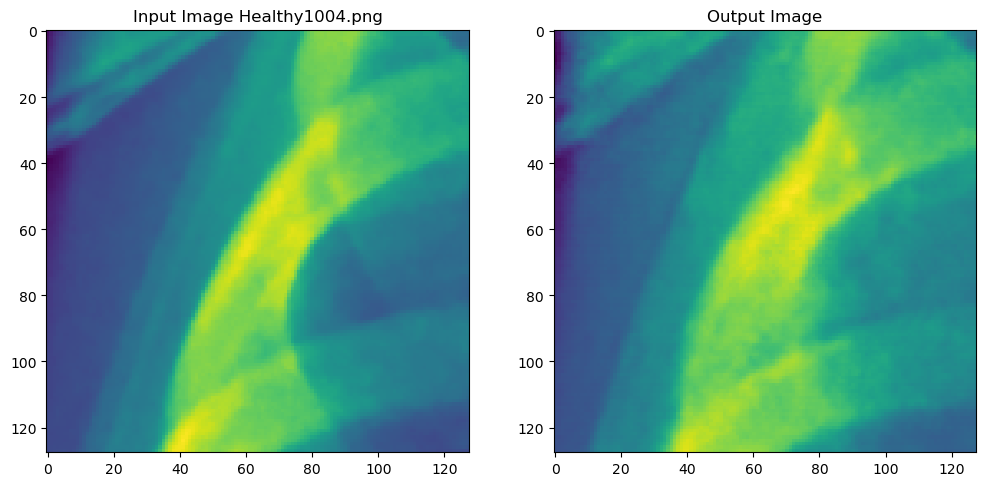

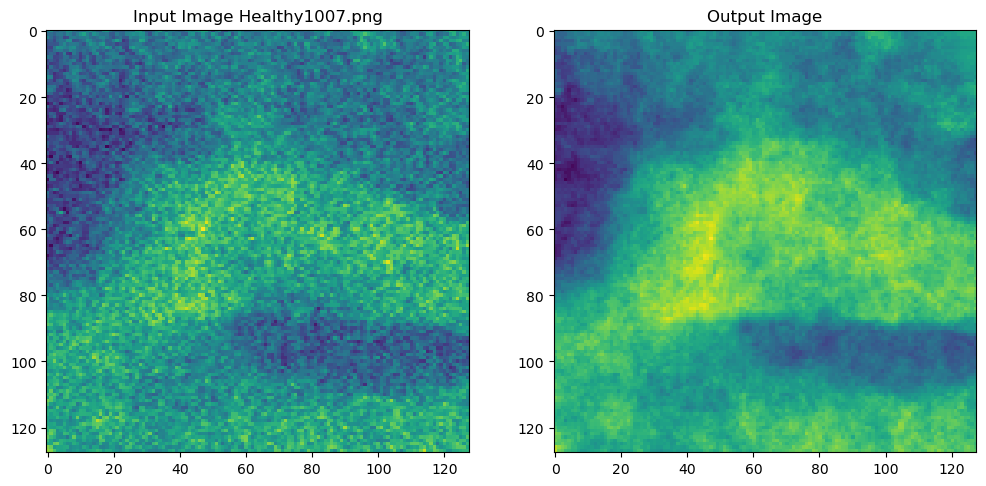

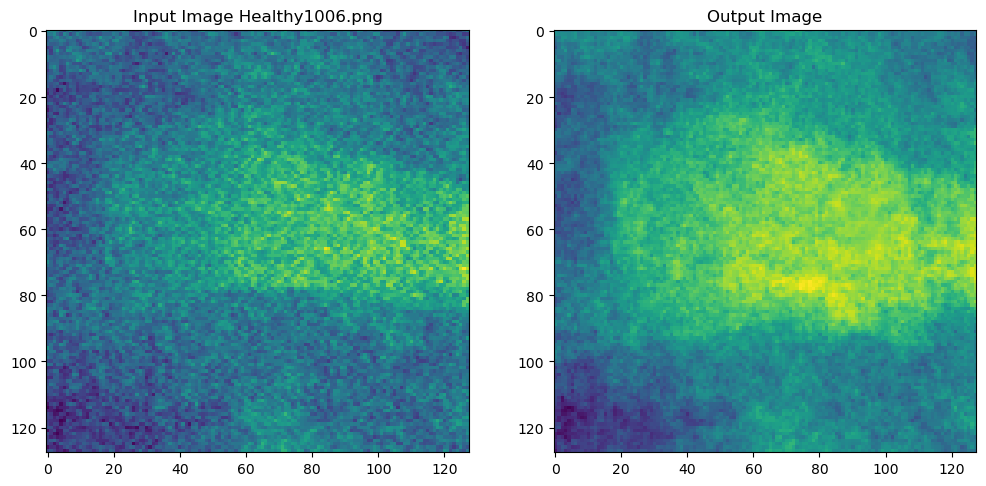

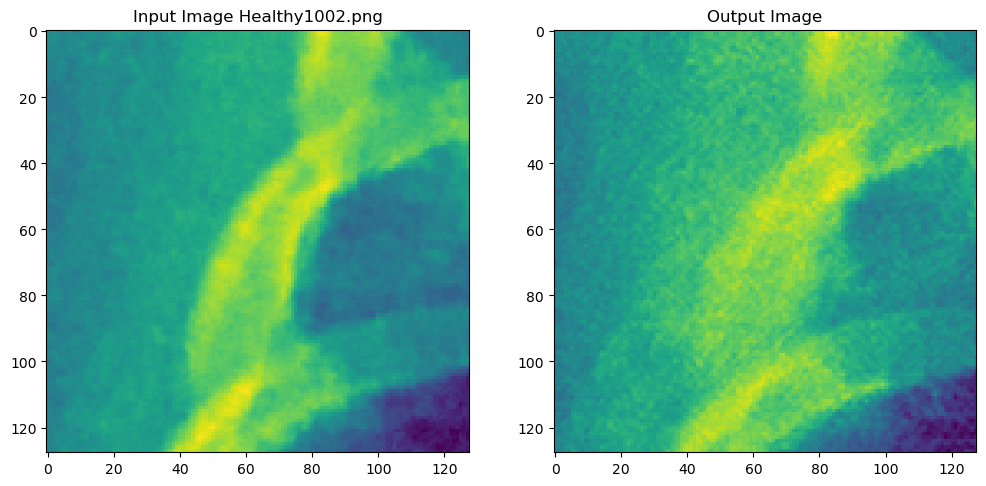

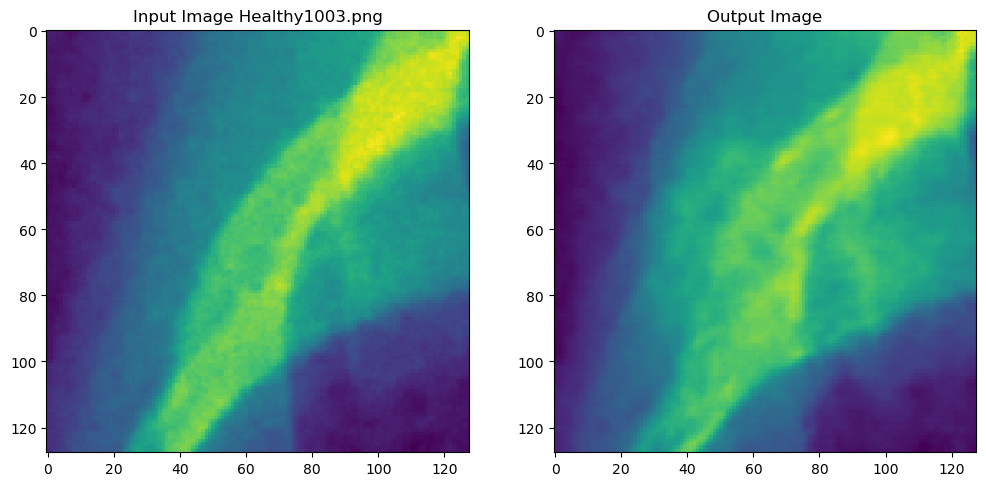

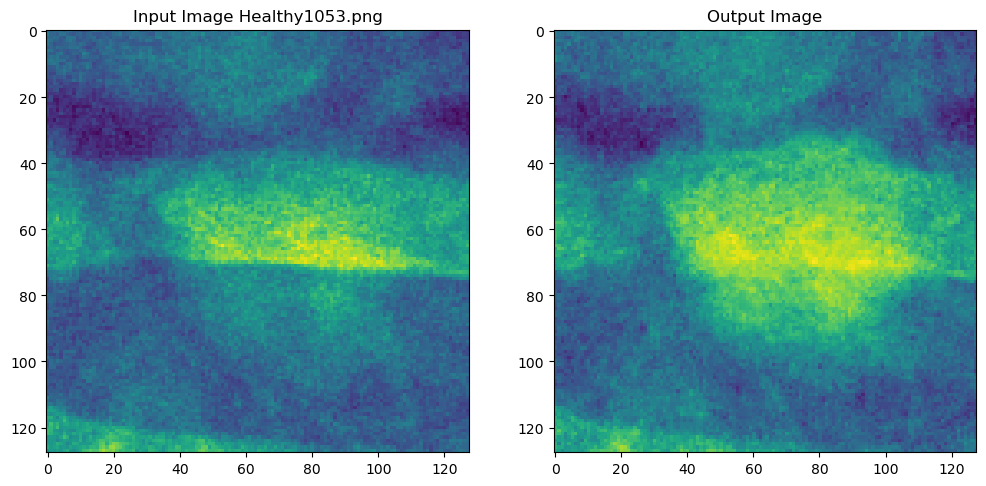

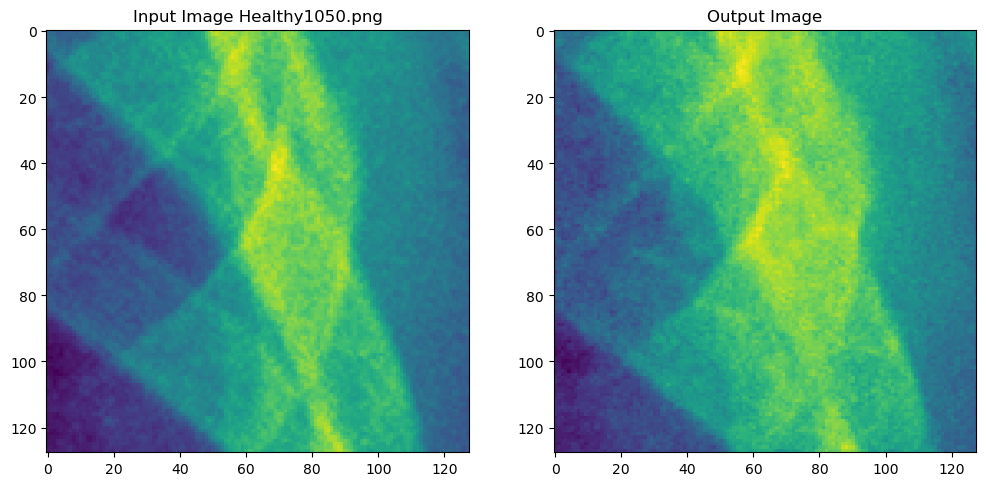

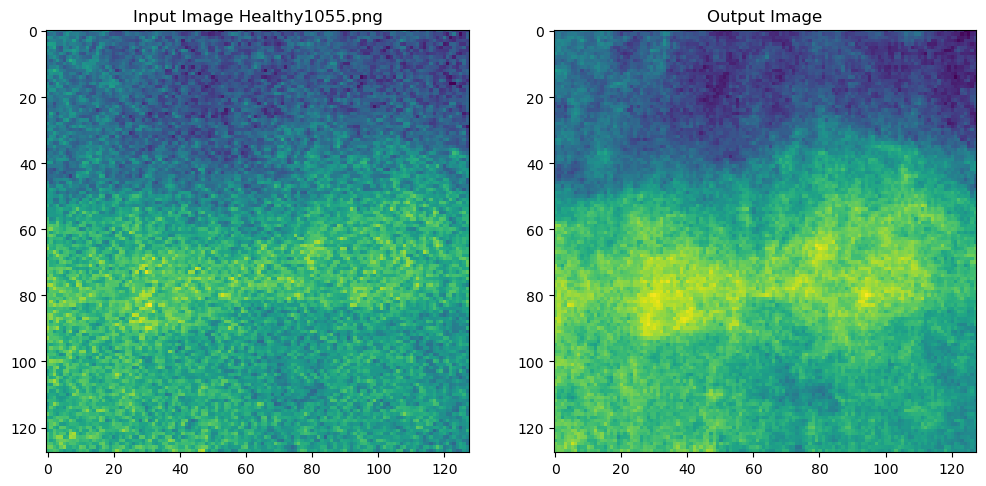

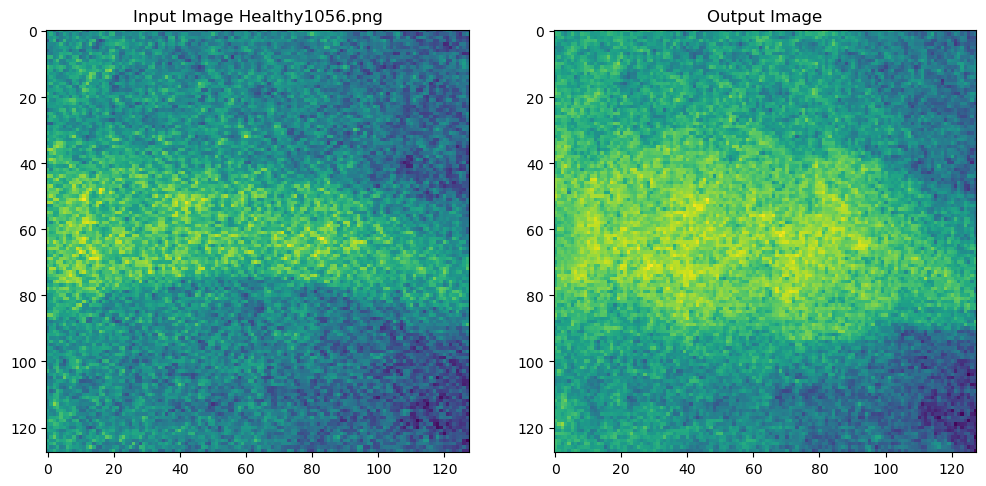

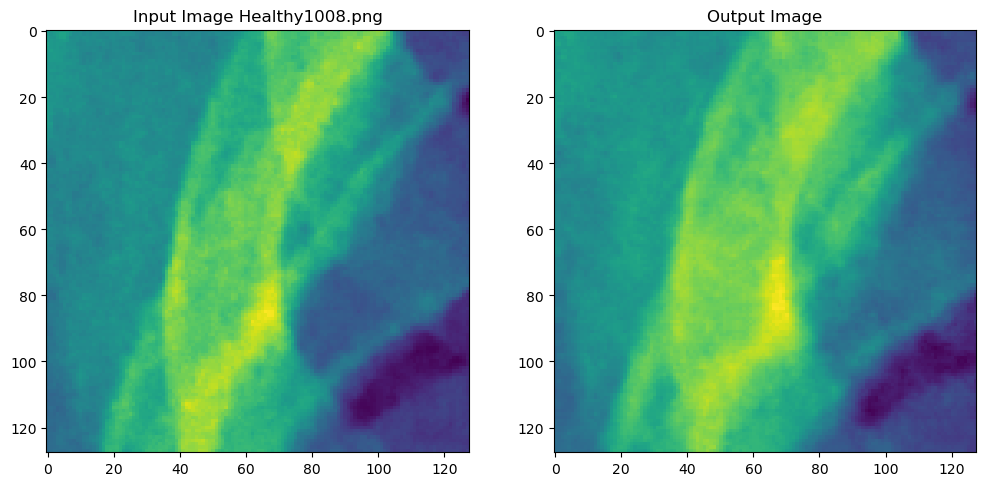

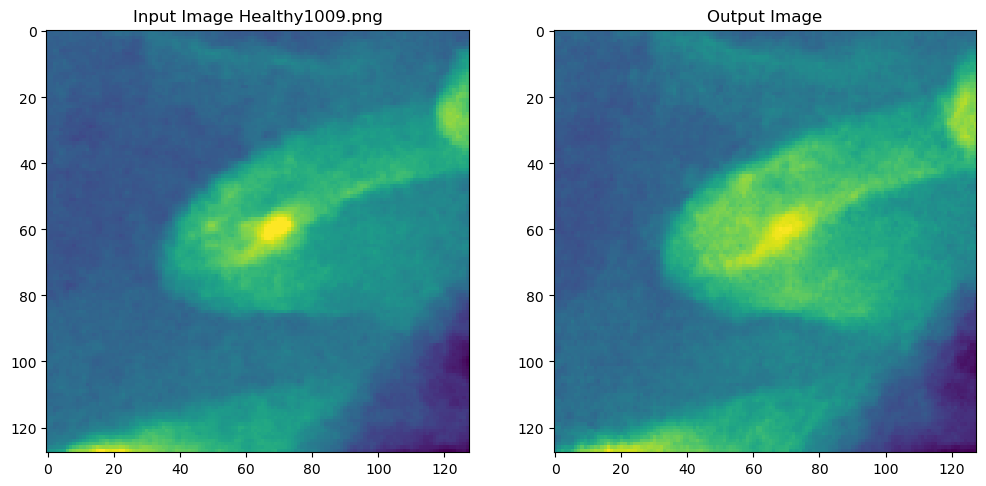

In [4]:
import glob
import os
import matplotlib.pyplot as plt
from PIL import Image


# Directory containing the images
image_dir = 'example_fracture_absent_patches'

# Get a list of image file paths
image_paths = glob.glob(os.path.join(image_dir, '*.png'))

# Load and preprocess the input image
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))  # Resize to the model's expected input size
    
    image = image/np.max(image) # Normalize to [0, 1]
    image_np = np.array(image).astype(np.float32)  
    #image_np = np.transpose(image_np, (2, 0, 1))  # Change to CHW format
    image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension
    image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension
    return image, image_np

# Display the input and output images
def display_images(input_image, output_image,file_now=''):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Input Image '+file_now)
    plt.imshow(input_image)

    plt.subplot(1, 2, 2)
    plt.title('Output Image')
    plt.imshow(output_image)

    plt.show()

# Loop through the image file paths
for image_path in image_paths:
    # Load and preprocess the input image
    input_image, input_data = load_image(image_path)

    # Run the model
    outputs = session.run([output_name], {input_name: input_data})

    output_data = outputs[0]
    output_image = np.squeeze(output_data, axis=0)  # Remove batch dimension
    output_image = np.transpose(output_image, (1, 2, 0))  # Change to HWC format
    output_image = np.clip(output_image, 0, 1)  # Ensure values are within [0, 1]

    # Display input and output images
    display_images(input_image, output_image,image_path.split('/')[-1])
